# Датасет MSLR (Microsoft Learning to Rank)

В этом примере мы:
- увидим как выглядят датасеты для обучения ранжированию на примере стандартного датасета MSLR
- получим несколько простых бейзлайнов качества ранжирования, которые потом будем пытаться побить

## Пререквизиты

Импортируем все что нам понадобится для дальнейшей работы:

In [1]:
from timeit import default_timer as timer

import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model

import catboost
from catboost import datasets, utils

## Стандартные датасеты для машинного обучения ранжированию

Существуют несколько стандартных датасетов, на которых рисерчеры сравнивают качество различных алгоритмов и моделей для решения задачи ранжирования.

Самые известные из таких датасетов -- это датасеты от компании Microsoft:
- LETOR (Learning to Rank for Information Retrieval): https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/
- MSLR (Microsoft Learning to Rank): https://www.microsoft.com/en-us/research/project/mslr/

Эти и им подобные датасеты выглядят примерно одинаково -- это просто большие таблицы, где каждая строка соответствуют объекту -- паре запрос-документ.

Объекты представлены в виде признаков, обычно их бывает от нескольких десятков до нескольких тысяч.<br>
Ответом (таргетом) может быть либо асессорская оценка, либо какая-то поведенческая статистика, например число кликов в данный документ по данному запросу.<br>
И, самое главное, в таком датасете обязательно должно быть колонка с ID запроса, которая позволяет связать объекты, относящиеся к одному и тому же запросу, т.е. это именно те объекты, которые мы хотим ранжировать.

Дальше в этом тюториале мы также будем использовать датасет MSLR:
- сначала проведем на нем EDA
- и потом попробуем получить несколько простых бейзлайнов, таких как случайное ранжирование, ранжирование по фиче и простая линейная модель

А в дальнейших примерах будем пытаться побить эти бейзлайны с помощью библиотек *catboost*, *xgboost* и *lightgbm*.

## Знакомство с датасетом MSLR

Полный датасет MSLR можно скачать с официального сайта: https://www.microsoft.com/en-us/research/project/mslr/

Этот датасет представлен в двух вариантах:
- MSLR-WEB10K в котором содержатся данные для 10 тыс. поисковых запросов
- MSLR-WEB30K еще больше и содержит 30 тыс. запросов

10 тыс. запросов это довольно много, и модели на таком датасете будут учиться долго, поэтом дальше мы будем использовать маленький сэмпл из MSLR-WEB10K всего на 175 запросов. 

Этот сэмпл уже доступен в библиотеке *catboost*, что очень удобно.

Загрузим его:

In [2]:
df_train, df_test = datasets.msrank_10k()

Датасет представляет собой обычный табличный датасет из 130 колонок:
- В первой колонке лежит таргет (оценка асессора), по 5-балльной шкале релевантности: от 0 до 4 (включительно)
- Во второй колонке лежит ID запроса, по которому можно сгруппировать все оценки документов в рамках одного и того же запроса
- Дальше идет вектор из 128 фичей (таких как значения BM25 и т.п.), их точная природа нам сейчас на важна

Посмотрим на данные:

In [3]:
df_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2.0,1,3,3,0,0,3,1.0,1.0,0.000000,...,62,11089534,2,116,64034,13,3,0,0,0.0
1,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,54,11089534,2,124,64034,1,2,0,0,0.0
2,0.0,1,3,0,2,0,3,1.0,0.0,0.666667,...,45,3,1,124,3344,14,67,0,0,0.0
3,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,56,11089534,13,123,63933,1,3,0,0,0.0
4,1.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,64,5,7,256,49697,1,13,0,0,0.0


Для удобства присвоим колонкам говорящие имена:

In [4]:
def generate_column_names(num_features):
    """Generates column names for LETOR-like datasets"""
    columns = ['label', 'qid']
    for i in range(num_features):
        column = f"feature_{i+1}"
        columns.append(column)
    return columns

# Assign column names
columns = generate_column_names(num_features=136)
df_train.columns = columns
df_test.columns = columns

Теперь наши данные выглядят понятнее:

In [5]:
df_train.head(5)

,label,qid,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136
0,2.0,1,3,3,0,0,3,1.0,1.0,0.000000,...,62,11089534,2,116,64034,13,3,0,0,0.0
1,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,54,11089534,2,124,64034,1,2,0,0,0.0
2,0.0,1,3,0,2,0,3,1.0,0.0,0.666667,...,45,3,1,124,3344,14,67,0,0,0.0
3,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,56,11089534,13,123,63933,1,3,0,0,0.0
4,1.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,64,5,7,256,49697,1,13,0,0,0.0


Проведем небольшой EDA.

Всего у нас 10000 документов в трейне:

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 138 entries, label to feature_136
dtypes: float64(97), int64(41)
memory usage: 10.5 MB


И 10000 документов в тесте:

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 138 entries, label to feature_136
dtypes: float64(97), int64(41)
memory usage: 10.5 MB


Сколько у нас запросов?

In [8]:
num_queries_train = df_train['qid'].nunique()
num_queries_test = df_test['qid'].nunique()
print(f"Got {num_queries_train} train and {num_queries_test} test queries")

Got 87 train and 88 test queries


Получается, у нас примерно по 100 документов на запрос.

Это типично, когда, например, для сбора датасета обкачивались и заливались на оценку топ-100 документов поисковой выдачи по случайным запросам.

Посмотрим на это распределение более детально:

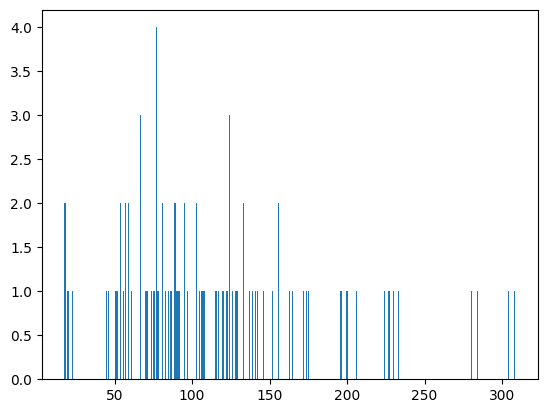

In [9]:
num_docs_by_qid = df_train.groupby('qid')['label'].agg('count')
doc_counts = num_docs_by_qid.value_counts()
x = doc_counts.index.to_numpy()
y = doc_counts.to_numpy()
plt.bar(x, y)
plt.show()

Теперь посмотрим на распределение таргетов (оценок):

In [10]:
df_train['label'].value_counts()

label
0.0    5481
1.0    3000
2.0    1326
3.0     142
4.0      51
Name: count, dtype: int64

In [11]:
df_test['label'].value_counts()

label
0.0    5755
1.0    2830
2.0    1221
3.0     148
4.0      46
Name: count, dtype: int64

Чтобы двигаться дальше, представим датасет в виде 3-х массивов numpy:

- **y** -- вектор таргетов
- **X** -- тензор из фичей
- **q** -- вектор из ID запросов, которые позволяют сгруппировать все документы, которые относятся к одному и тому же запросу.

Напишем функцию, которая позволит это сделать, и применим ее к нашим датафреймам:

In [12]:
def to_numpy_dataset(df):
    y = df['label'].to_numpy()                       # Label: [0-4]
    q = df['qid'].to_numpy()                         # Query Id
    X = df.drop(columns=['label', 'qid']).to_numpy() # 136 features
    return (X, y, q)

X_train, y_train, q_train = to_numpy_dataset(df_train)
X_test, y_test, q_test = to_numpy_dataset(df_test)

print(f"Train: X_train.shape = {X_train.shape} y_train.shape = {y_train.shape} q_train.shape = {q_train.shape}")
print(f"Test: X_test.shape = {X_test.shape} y_test.shape = {y_test.shape} q_test.shape = {q_test.shape}")

Train: X_train.shape = (10000, 136) y_train.shape = (10000,) q_train.shape = (10000,)
Test: X_test.shape = (10000, 136) y_test.shape = (10000,) q_test.shape = (10000,)


## Бейзлайн #1: случайное ранжирование

Попробуем теперь получить несколько простых бейзлайнов качества поиска.

Самое простое, что вообще можно придумать -- это ранжировать документы в рамках запроса случайно:

In [13]:
# Зафкисируем seed генератора случайных чисел
np.random.seed(42)

# Получим случайные предикты для тестового множества
y_hat_test = np.random.uniform(size=len(y_test))

# Посчитаем метрику NDCG@10 с помощью функции из библиотеки catboost
scores = utils.eval_metric(y_test, y_hat_test, 'NDCG:top=10;type=Exp', group_id=q_test)
print(scores[0])

0.20081259554363048


У нас получилось NDCG@10 = 0.20 -- кажется, что это довольно мало.

Также, обратим внимание, что если в будущем у нас получится число *меньше* этого -- значит, мы просто ранжируем документы в обратном порядке!

## Бейзлайн #2: ранжирование по отдельным признакам

Следующий бейзлайн, который хотелось бы получить -- это ранжирование по отдельным фичам.

Идея тут в том, что в поисковых задачах очень часто используются "сильные" фичи, такие как TF-IDF, BM25 или косинус между эмбеддингами каких-то нейронок. Такие фичи и сами по себе должны хорошо ранжировать документы, поэтому перед обучением моделей всегда очень полезно попробовать ранжировать по каждой из фичей в отдельности.

Давайте попробуем это сделать:

In [14]:
num_features = X_test.shape[1]
best_ndcg = 0
best_feature_id = None

# Будем ранжировать по каждой из фичей
for i in range(num_features):
    feature_id = i + 1
    # Используем значение фичи в качестве предикта
    y_hat_test = X_test[:,i]

    # Считаем метрику NDCG
    scores = utils.eval_metric(y_test, y_hat_test, 'NDCG:top=10;type=Exp', group_id=q_test)
    ndcg = scores[0]
           
    if ndcg > best_ndcg:
        best_ndcg = ndcg
        best_feature_id = feature_id
print(f"Best feature: feature_id = {best_feature_id} best_ndcg = {best_ndcg:.3f}")

Best feature: feature_id = 110 best_ndcg = 0.287


Мы видим, что фича под номером 128 дает NDCG@10 = 0.287, что значительно лучше, чем просто рандом.

К сожалению, мы не знаем что именно это за фича, т.к. компания Microsoft не раскрыла эту информацию.

По хорошему, надо провести аналогичное исследование и с использованием значений фичей со знаком минус, т.к. вполне возможна ситуация, когда какая-то из фичей обратно коррелирует с таргетом. Оставим это в качестве упражнения.

## Бейзлайн #3: линейная регрессия на оценку

Теперь можно попробовать обучить какую-то модель.

Мы начнем с самого простого -- линейной регрессии из библиотеки *sklearn*.

Есть использовать терминологию машинного обучения ранжированию, то это _pointwise_ модель, которая в качестве лосса использует обычное RMSE.

Обучим модель:

In [15]:
model = linear_model.LinearRegression()

start = timer()
model.fit(X_train, y_train)
print(f"Fit linear regression: elapsed = {timer() - start:.3f}")

Fit linear regression: elapsed = 0.630


Видим, что модель обучилась очень быстро.

Применим ее к тестовому множеству, и померяем качество:

In [16]:
# Получаем предсказания
y_hat_test = model.predict(X_test)

# Считаем метрику NDCG@10
scores = utils.eval_metric(y_test, y_hat_test, 'NDCG:top=10;type=Exp', group_id=q_test)
print(scores[0])

0.34781016642087237


Мы получили NDCG@10 = 0.34, что уже значительно лучше чем давало ранжирование по отдельной фиче.

Даже на этом простом примере видна сила машинного обучения, т.к. комбинируя простые ранки (такие как BM25) мы можем получить качество поиска гораздно лучше, чем если бы мы использовали только BM25!

## Результаты

Соберем все наши результаты в табличку:
- рандом дал NDCG@10 = **0.20**
- лучшая из фичей дала NDCG@10 = **0.28**
- линейная регрессия из *sklearn* дала NDCG@10 = **0.34**


Дальше мы увидим, что эти результаты можно драматически улучшить с помощью моделей градиентного бустинга.